In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import tqdm
import matplotlib.pyplot as plt

import FSHA
import architectures
import datasets
from datasets import *

2024-05-28 21:37:00.155902: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 21:37:01.362601: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Choose experiment setup here:

In [4]:
dataset_name = "f_mnist" # 'mnist' or 'f_mnist'
split_layer = 4 # 1 <= split_layer <= 4
architecture = "mlp" # 'mlp' or 'cnn'

# Load datasets

2024-05-28 21:37:11.233318: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21731 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:89:00.0, compute capability: 8.0


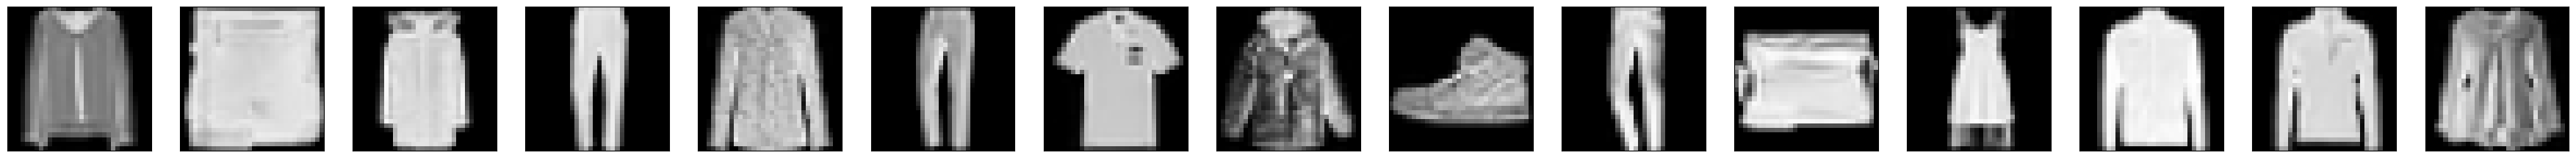

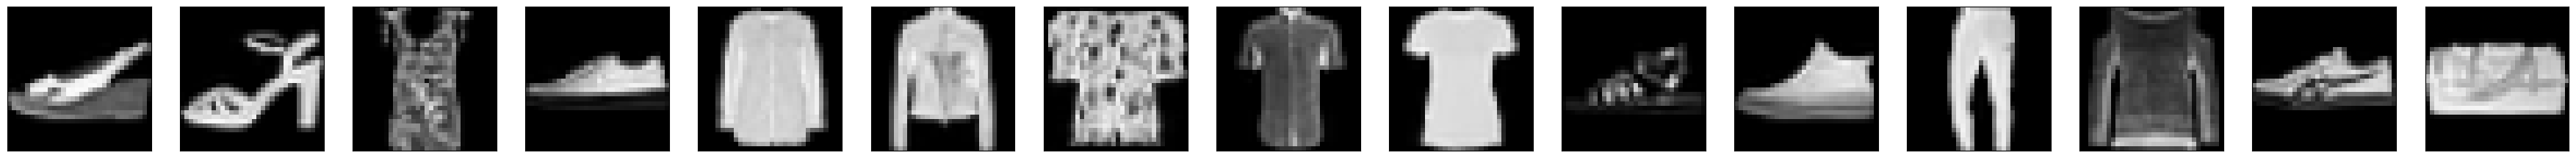

In [5]:
dataset_loader = load_mnist if dataset_name == "mnist" else load_fashion_mnist

xpriv, xpub = dataset_loader()

n = 15
x_priv = datasets.getImagesDS(xpriv, n)
x_pub = datasets.getImagesDS(xpub, n)

datasets.plot(x_priv)
datasets.plot(x_pub)

# Setup attack:

In [6]:
batch_size = 64
split_layer = 4
hparams = {
    'WGAN' : True,
    'gradient_penalty' : 500.,
    'style_loss' : None,
    'lr_f' :  0.00001,
    'lr_tilde' : 0.00001,
    'lr_D' : 0.0001,
}

fsha = FSHA.FSHA(xpriv, xpub, split_layer-1, batch_size, hparams, architecture="mlp")

[DECODER] activation:  None


# Run attack:

In [7]:
log_frequency = 100
LOG = fsha(5000, verbose=True, progress_bar=False, log_frequency=log_frequency)

RUNNING...
Use WGAN loss
Use GP
Use WGAN loss
Use GP


2024-05-28 21:37:27.491544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-05-28 21:37:27.532291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8906
2024-05-28 21:37:27.801826: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-28 21:37:29.370296: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fb6e28d0440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-28 21:37:29.370359: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-05-28 21:37:29.378302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-28 21:37:29.466181:

log--00%-0000000] validation: 0.6596
log--02%-0000100] validation: 0.5376
log--04%-0000200] validation: 0.2831
log--06%-0000300] validation: 0.2781
log--08%-0000400] validation: 0.3052
log--10%-0000500] validation: 0.2993
log--12%-0000600] validation: 0.3147
log--14%-0000700] validation: 0.3528
log--16%-0000800] validation: 0.3686
log--18%-0000900] validation: 0.4194
log--20%-0001000] validation: 0.4272
log--22%-0001100] validation: 0.4302
log--24%-0001200] validation: 0.4570
log--26%-0001300] validation: 0.4386
log--28%-0001400] validation: 0.4674
log--30%-0001500] validation: 0.4747
log--32%-0001600] validation: 0.4801
log--34%-0001700] validation: 0.4793
log--36%-0001800] validation: 0.4927
log--38%-0001900] validation: 0.5062
log--40%-0002000] validation: 0.5142
log--42%-0002100] validation: 0.5013
log--44%-0002200] validation: 0.4845
log--46%-0002300] validation: 0.4777
log--48%-0002400] validation: 0.4864
log--50%-0002500] validation: 0.5019
log--52%-0002600] validation: 0.5084
l

# Plot logs:

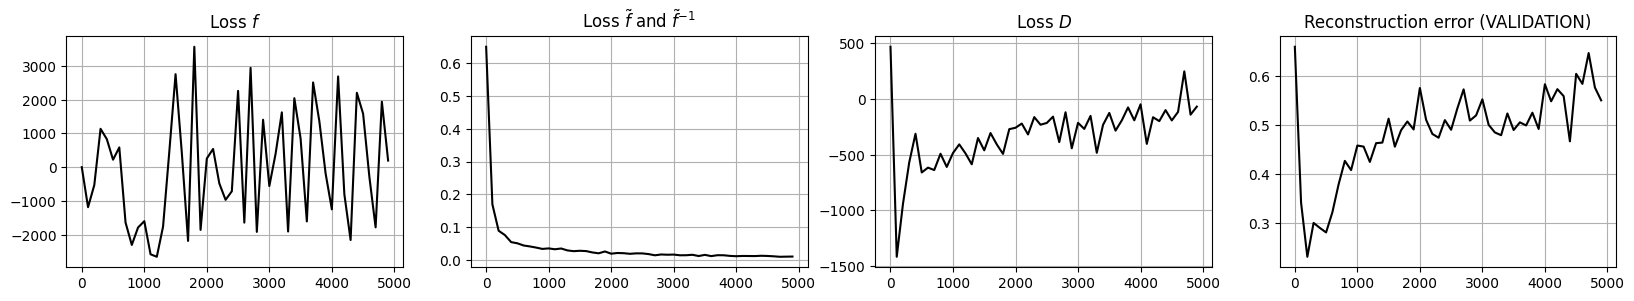

In [8]:
def plot_log(ax, x, y, label):
    ax.plot(x, y, color='black')
    ax.set(title=label)
    ax.grid()

n = 4
fix, ax = plt.subplots(1, n, figsize=(n*5, 3))
x = np.arange(0, len(LOG)) * log_frequency 

plot_log(ax[0], x, LOG[:, 0], label='Loss $f$')
plot_log(ax[1], x, LOG[:, 1],  label='Loss $\\tilde{f}$ and $\\tilde{f}^{-1}$')
plot_log(ax[2], x, LOG[:, 2],  label='Loss $D$')
plot_log(ax[3], x, LOG[:, 3],  label='Reconstruction error (VALIDATION)')

# Plot reconstruction private data:

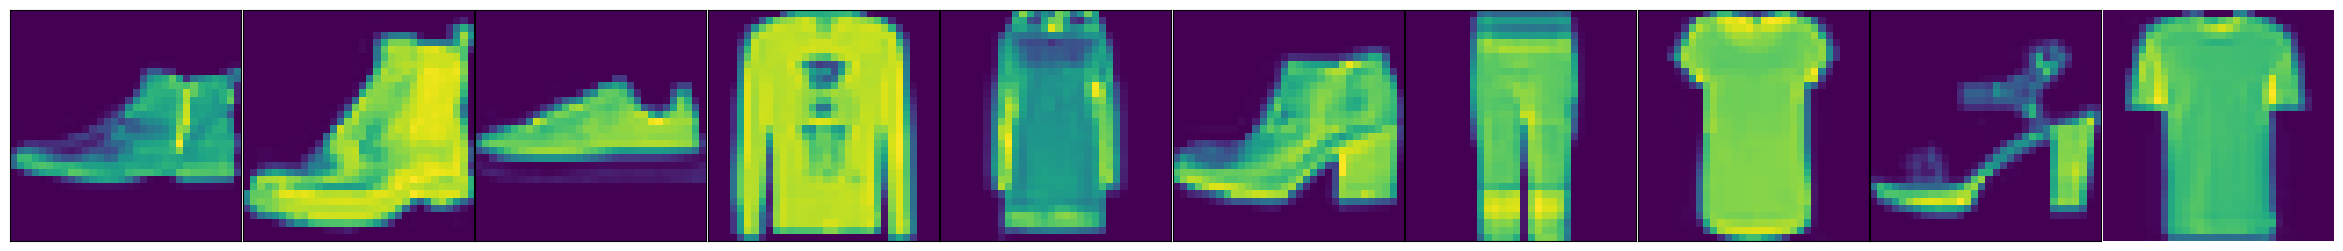

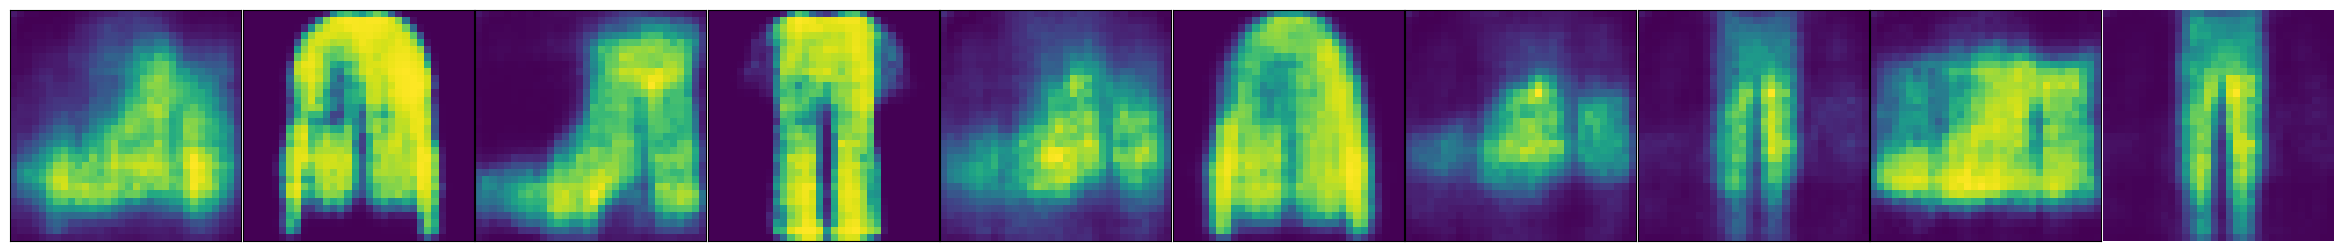

In [9]:
n = 10
X = getImagesDS(xpriv, n)
X_recovered, control = fsha.attack(X)

def plot(X):
    n = len(X)
    X = (X+1)/2
    fig, ax = plt.subplots(1, n, figsize=(n*3,3))
    plt.axis('off')
    plt.subplots_adjust(wspace=0, hspace=-.05)
    for i in range(n):
        ax[i].imshow((X[i, :, :, 0]));  
        ax[i].set(xticks=[], yticks=[])
        ax[i].set_aspect('equal')
        
    return fig


fig = plot(X)
fig = plot(X_recovered)